In [1]:
#! pip install -U pip setuptools wheel
#! pip install -U spacy
#! python -m spacy download en_core_web_lg    #large pretrained model containing word2vec embeddings

#! pip install -U scikit-learn

In [2]:
import os
import sys
import time
import random
import datetime
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

# We will use spaCy to get pretrained word2vec-style  embeddings for image textual Tag.
import spacy    
import en_core_web_lg # Large EN language model. Contains GloVe Common Crawl word2vec model trained at the GloVe project.
nlp = en_core_web_lg.load() #The spaCy pretrained pipeline

from ipywidgets import FloatProgress

from sklearn.manifold import TSNE

# Load  MET Data (csv version)

In [3]:
root_directory = os.path.dirname(os.getcwd())
current_directory = os.getcwd()

print(root_directory)
print(current_directory)

PATH_DATA = root_directory + '/TestIDC/'

/Users/kyazigee/WORK
/Users/kyazigee/WORK/TestIDC


In [4]:
MISSING_VALUES = ['-','.']
DATES = []
_unicode = {}
dataset = 'MetObjects'

primary_key = 'Object_ID'
time_stamp = 'Object_End_Date'
grouping_criterion ='Tags'

met = pd.read_csv(PATH_DATA + dataset + ".csv", encoding = 'utf-8', na_values = MISSING_VALUES, decimal = ';', sep = ',' 
                  ,  dayfirst = True, parse_dates = DATES,  dtype= _unicode )

# Use proper column names (code sugar,not necessary here).
cols_propername = [col.replace(' ', '_') for col in list(met.columns)]
met.columns = cols_propername


# For simplicity, we focus in this excersise  only on Drawings and Painings (faster execution).
mask = met['Object_Name'].isin(['Drawing','Painting'])
met = met[mask]
print('subset of Darwings and Paintings shape : ',  met.shape)

# Furthermore, we retain only the records where the 'Tags' field is not null
mask = pd.notnull(met[grouping_criterion])
met = met[mask]
print('subset of Darwings and Paintings with available Tag shape : ',  met.shape)

met= met.reset_index(drop = True)

/var/folders/z5/3jfg0cs911n90835bkyqyy8m0000gn/T/ipykernel_11165/2512083039.py:10: DtypeWarning: Columns (5,7,10,11,12,13,14,34,35,36,37,38,39,40,41,42,43,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  met = pd.read_csv(PATH_DATA + dataset + ".csv", encoding = 'utf-8', na_values = MISSING_VALUES, decimal = ';', sep = ','


subset of Darwings and Paintings shape :  (31720, 54)
subset of Darwings and Paintings with available Tag shape :  (25328, 54)


## Decomposition of 'Tags' field into entities (n-gram word tokens)

In [5]:
VOCABULARY = set(nlp.vocab.strings)
print(len(VOCABULARY))

776469


In [6]:
#Each Tags has the form  'Entity1|Entity2|Entity3|..|EntityN'. The '|' seperator means 'AND'

# Individual EntityXs are mostly PROPER NOUNS, but can also be other named entities, e.g. PERSONs.
# They are generally n-gram words (n  = mostly 1 or 2).
# The benefit of using the loaded spaCy model is that it is a NET (Named Entity Recognition) model so it 
# [trained]embeddings are sensitive to the entity type.#

In [7]:
# get list of unique Tokens from 'Tags' field.
s = []
for value in set(met['Tags'].values):
    if pd.notnull(value):
        s += value.split('|')   # remove the '|' separator.
tag_entities = set(s)

print('number of unique entities :', len(tag_entities)) # PS: these foloow Ziff's law.

# See how many of the unique entities are mappable to an embedding vector using the imported language model.
has_embedding= []
for entity in tag_entities:  # only one category, can be > 1-ngram, e.g. 'Females Nude'
    if nlp(entity).has_vector == True:
        has_embedding.append(entity)
        
print('percentage of unique entities that have an embedding :', 100*len(has_embedding)/len(tag_entities))

# we get 97% so we can live with that as it is.

number of unique entities : 933
percentage of unique entities that have an embedding : 97.53483386923901


# Vectorize Tags information (avg of Word2Vec embeddings of indiviual Tag entities)

In [8]:
def vectoraize(tag):
    if pd.notnull(tag):
        s = set(tag. split('|'))  # string --> lists of tokens
        s = list(s.intersection(has_embedding)) # kick out tokens witout embeddings.
        s = ' '.join(s) # list -back to -> string
        return nlp(s).vector  # apply spaCy pretrained pipeline on the whole string 
                               # which outputs the string embedding.
    else:
        return np.zeros(300)  # This will never happen as we have pre-filtered for not null Tags. Here for sake of completeness.

# Create dense pandas dataframe with the embeddings.

met_Tag_embeddings = pd.DataFrame()
V = met['Tags'].values

f = FloatProgress(description='Progress:', min = 0, max = len(V))
display(f)

warnings.filterwarnings('ignore')

i =0
for v in V:
    arr = vectoraize(v)
    met_Tag_embeddings[i] = arr #columns are Tag IDs and rows embedding dimensions
    i+=1
    f.value += 1
        
warnings.filterwarnings('once')

FloatProgress(value=0.0, description='Progress:', max=25328.0)

## remove unmappable Tags

In [9]:
met_Tag_embeddings = met_Tag_embeddings.T

def isZero(row):
    isZero = 1
    for c in range(0,300):
        if row[c] != 0:
            isZero = 0
            break
            
    return isZero

met_Tag_embeddings['isZero'] = met_Tag_embeddings.apply(lambda row: isZero(row), axis = 1)


TagEmbeddedMet = pd.concat([met[['Object_ID', 'Is_Highlight','Object_End_Date', 'Tags']],met_Tag_embeddings], axis = 1) 
mask = TagEmbeddedMet['isZero'] == 0

print('pct of Tags that could not be vectorized : ')
print(100*TagEmbeddedMet[~mask].shape[0]/ TagEmbeddedMet.shape[0], '%')
print('Very small pct, so just drop it. No big deal')

TagEmbeddedMet = TagEmbeddedMet[mask]
TagEmbeddedMet = TagEmbeddedMet.reset_index(drop = True)

pct of Tags that could not be vectorized : 
0.5566961465571699 %
Very small pct, so just drop it. No big deal


In [10]:
TagEmbeddedMet.head()

,Object_ID,Is_Highlight,Object_End_Date,Tags,0,1,2,3,4,5,...,291,292,293,294,295,296,297,298,299,isZero
0,150,False,1889,Feet|Heads|Dancers,0.949233,1.677956,-2.388463,1.147037,3.024500,-0.216470,...,-1.340490,0.386183,2.066767,-1.728000,-0.507273,0.758043,-1.580133,-1.844073,2.377133,0
1,194,False,1878,Birds|Men|Women|Hieroglyphs|Hunting,0.119659,-0.192720,1.618258,0.751214,2.625408,-0.231614,...,0.181756,1.499422,3.059426,-3.385230,-1.303292,3.161523,-2.967220,-3.957720,1.243618,0
2,466,False,1883,Benjamin Franklin|Men|Portraits,-3.053792,0.257890,0.455217,-0.476275,1.988760,-2.005630,...,-1.104130,0.909705,2.310382,-2.832798,-0.956293,2.917697,0.576988,-1.010900,-0.521725,0
3,467,False,1883,Benjamin Franklin|Men|Portraits,-3.053792,0.257890,0.455217,-0.476275,1.988760,-2.005630,...,-1.104130,0.909705,2.310382,-2.832798,-0.956293,2.917697,0.576988,-1.010900,-0.521725,0
4,468,False,1883,Benjamin Franklin|Men|Portraits,-3.053792,0.257890,0.455217,-0.476275,1.988760,-2.005630,...,-1.104130,0.909705,2.310382,-2.832798,-0.956293,2.917697,0.576988,-1.010900,-0.521725,0


## Sanity check for embeddings : Hierarchical clustering based on Word2Vec embeddings and then inspect clusters

In [11]:
embedding_columns = np.arange(0,300)
L = list(TagEmbeddedMet.index)
k = TagEmbeddedMet.shape[0]
sample = random.sample(L,k)
X = TagEmbeddedMet.iloc[sample]

## perform Hieararchical clustering based on embeddings

In [12]:
model = AgglomerativeClustering(n_clusters = 12, metric = 'euclidean', linkage = 'ward').\
            fit(X[embedding_columns])

## create 2D t-SNE probabilistic projections

In [13]:
embedding_columns = list(np.arange(0,300))
X_embedded = TSNE(n_components=3, learning_rate='auto', random_state=0,
                  init='pca', perplexity=30).fit_transform(X[embedding_columns])

In [14]:
X['cluster'] = model.labels_

tsne_df = pd.DataFrame(data = {
    "CLUSTER": X['cluster'],
    "x": [value[0] for value in X_embedded],
    "y": [value[1] for value in X_embedded],
    "z": [value[2] for value in X_embedded]
})
tsne_df = tsne_df.reset_index(drop = True)
tsne_df.head()

/var/folders/z5/3jfg0cs911n90835bkyqyy8m0000gn/T/ipykernel_11165/2144508725.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = model.labels_


,CLUSTER,x,y,z
0,2,37.521240,47.644913,39.745346
1,2,5.758818,-10.823540,-13.807310
2,4,37.215584,46.955055,-40.853722
3,2,7.314056,3.378639,-3.314767
4,10,-24.846975,-17.393644,31.323048


## Visualize cluster composition in terms of otiginal Tags and in 2D t_SNE compressed coordinates

/var/folders/z5/3jfg0cs911n90835bkyqyy8m0000gn/T/ipykernel_11165/2974849473.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = top7.index, rotation=45, ha='right', fontsize = 10)
/var/folders/z5/3jfg0cs911n90835bkyqyy8m0000gn/T/ipykernel_11165/2974849473.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = top7.index, rotation=45, ha='right', fontsize = 10)


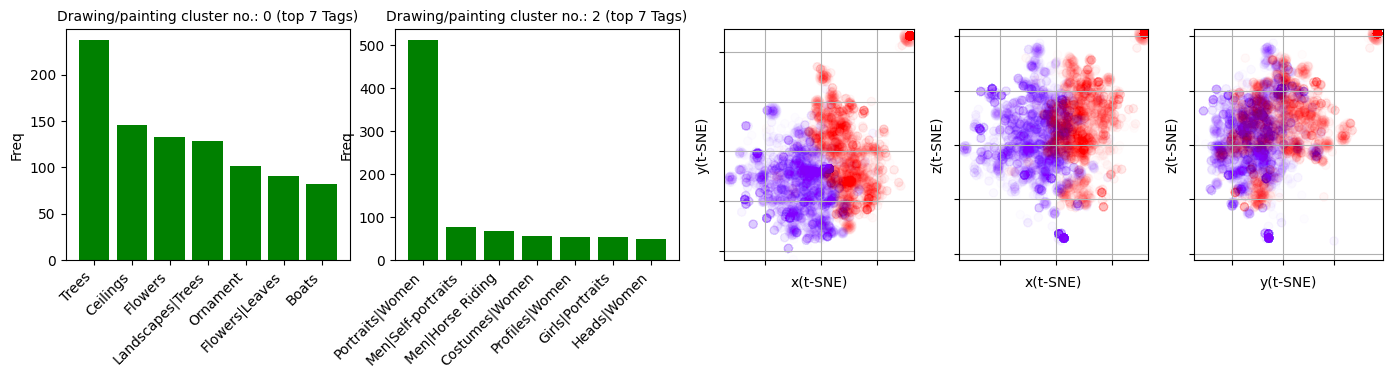

/var/folders/z5/3jfg0cs911n90835bkyqyy8m0000gn/T/ipykernel_11165/2974849473.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = top7.index, rotation=45, ha='right', fontsize = 10)
/var/folders/z5/3jfg0cs911n90835bkyqyy8m0000gn/T/ipykernel_11165/2974849473.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = top7.index, rotation=45, ha='right', fontsize = 10)


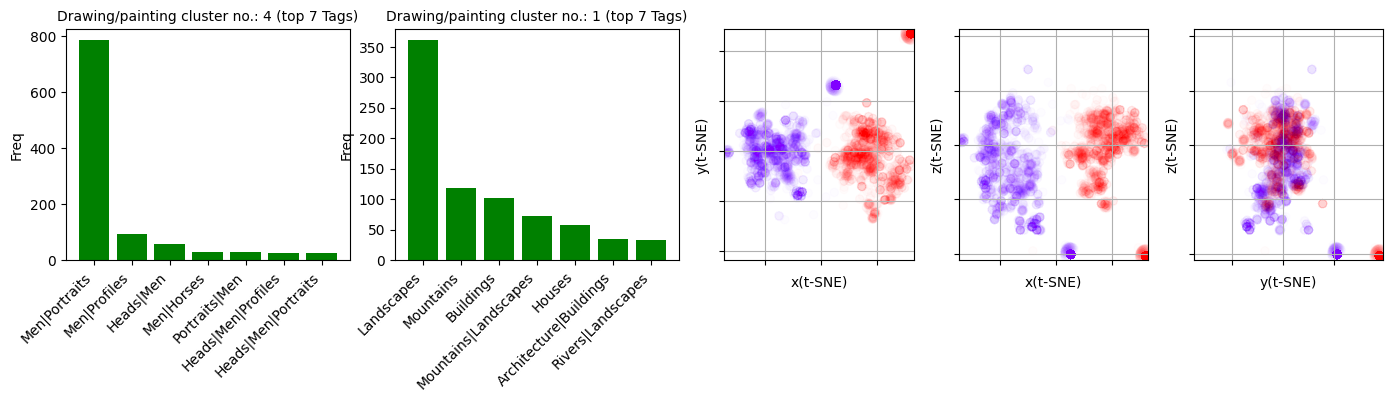

/var/folders/z5/3jfg0cs911n90835bkyqyy8m0000gn/T/ipykernel_11165/2974849473.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = top7.index, rotation=45, ha='right', fontsize = 10)
/var/folders/z5/3jfg0cs911n90835bkyqyy8m0000gn/T/ipykernel_11165/2974849473.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = top7.index, rotation=45, ha='right', fontsize = 10)


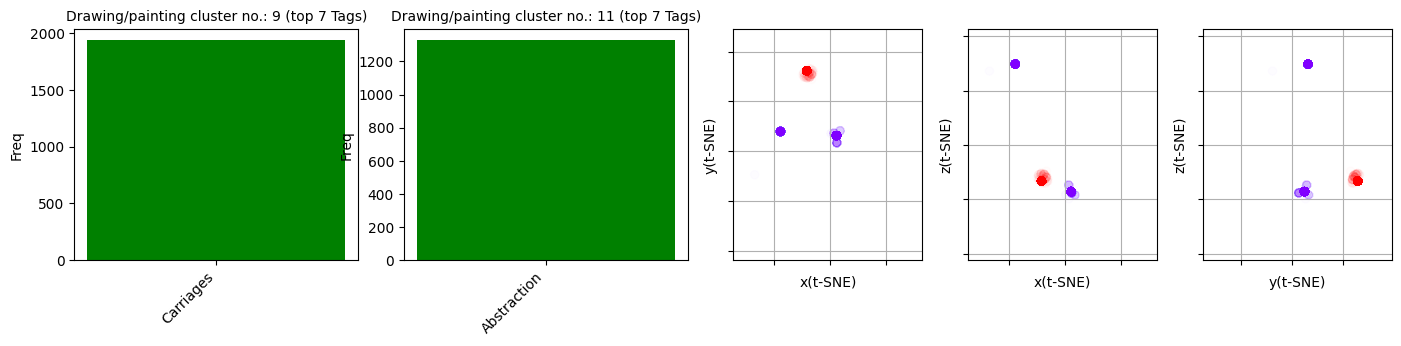

/var/folders/z5/3jfg0cs911n90835bkyqyy8m0000gn/T/ipykernel_11165/2974849473.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = top7.index, rotation=45, ha='right', fontsize = 10)
/var/folders/z5/3jfg0cs911n90835bkyqyy8m0000gn/T/ipykernel_11165/2974849473.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = top7.index, rotation=45, ha='right', fontsize = 10)


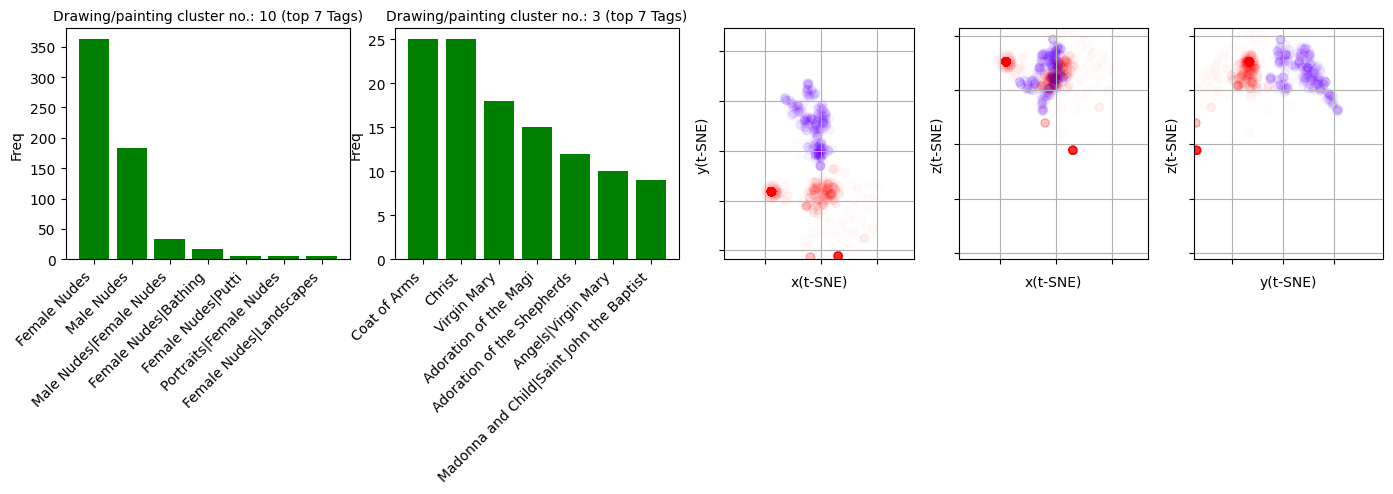

/var/folders/z5/3jfg0cs911n90835bkyqyy8m0000gn/T/ipykernel_11165/2974849473.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = top7.index, rotation=45, ha='right', fontsize = 10)
/var/folders/z5/3jfg0cs911n90835bkyqyy8m0000gn/T/ipykernel_11165/2974849473.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = top7.index, rotation=45, ha='right', fontsize = 10)


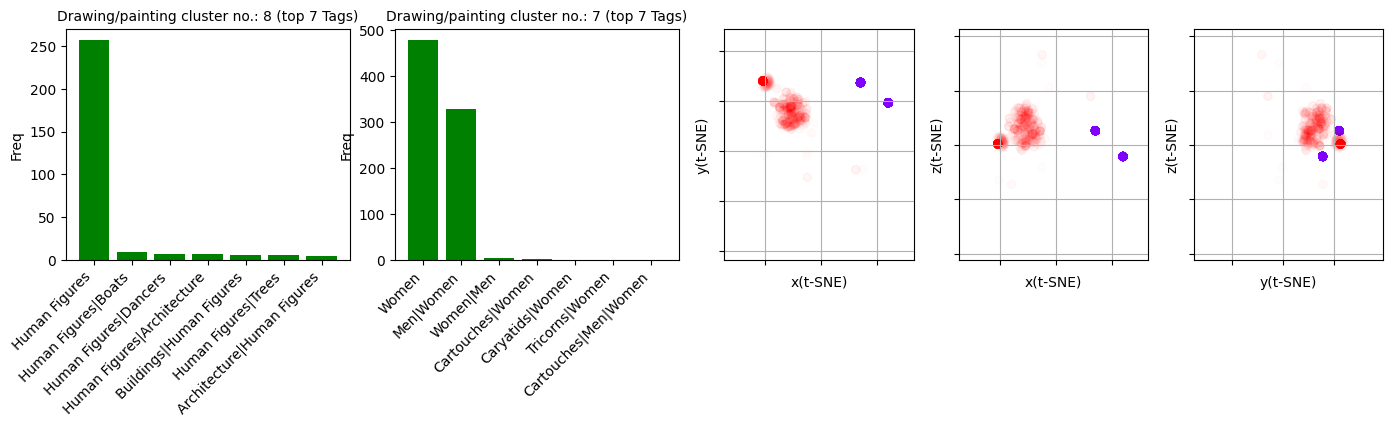

/var/folders/z5/3jfg0cs911n90835bkyqyy8m0000gn/T/ipykernel_11165/2974849473.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = top7.index, rotation=45, ha='right', fontsize = 10)
/var/folders/z5/3jfg0cs911n90835bkyqyy8m0000gn/T/ipykernel_11165/2974849473.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = top7.index, rotation=45, ha='right', fontsize = 10)


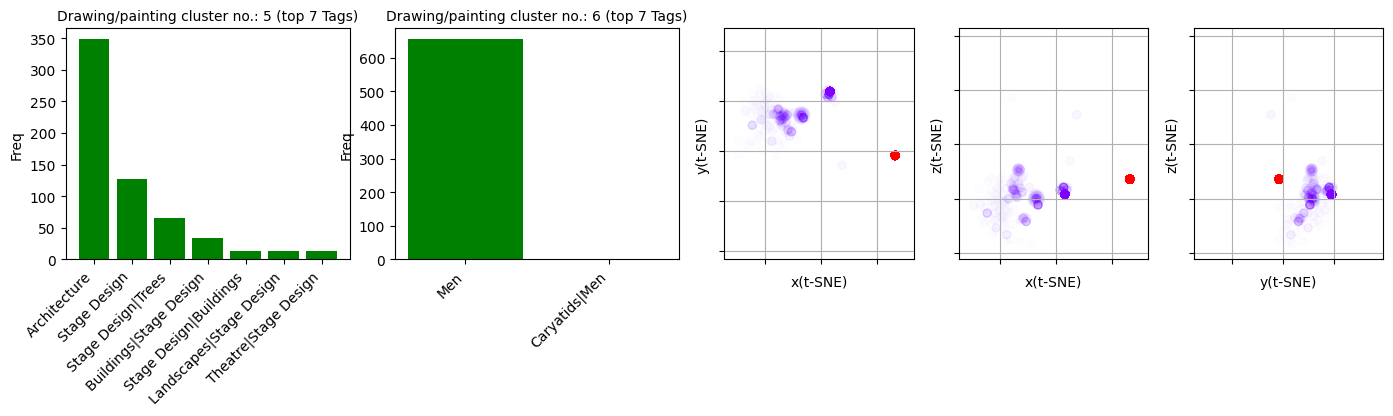

In [15]:
from matplotlib import gridspec

last_index = 0
I = X['cluster'].value_counts().index

for i in range(0,6):
    
    fig = plt.figure(figsize=(17,3))

    gs =  gridspec.GridSpec(1, 5, width_ratios=[3,3,2,2,2])
    gsp00 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = gs[0])
    gsp01 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = gs[1])
    gsp02 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = gs[2])
    gsp03 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = gs[3])
    gsp04 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = gs[4])

    ax = fig.add_subplot(gsp00[0,0])
    cluster = I[last_index]
    mask =  X['cluster'] == cluster
    ax.set_title('Drawing/painting cluster no.: ' + str(cluster) + ' (top 7 Tags)', fontsize = 10)
    ax.set_ylabel('Freq')
    stats = X[mask]['Tags'].value_counts()
    top7 = stats[0:7]
    ax.bar(top7.index, top7.values, color = 'green')
    ax.set_xticklabels(labels = top7.index, rotation=45, ha='right', fontsize = 10)

    ax = fig.add_subplot(gsp01[0,0])
    cluster = I[last_index+1]
    mask =  X['cluster'] == cluster
    ax.set_title('Drawing/painting cluster no.: ' + str(cluster) + ' (top 7 Tags)', fontsize = 10)
    ax.set_ylabel('Freq')
    stats = X[mask]['Tags'].value_counts()
    top7 = stats[0:7]
    ax.bar(top7.index, top7.values, color = 'green')
    ax.set_xticklabels(labels = top7.index, rotation=45, ha='right', fontsize = 10)
    
    ax = fig.add_subplot(gsp02[0,0])
    mask = tsne_df['CLUSTER'].isin([ I[last_index], I[last_index+1] ] )
    colors = tsne_df[mask]['CLUSTER']
    ax.scatter(tsne_df[mask]['x'], tsne_df[mask]['y'] , c = colors ,  cmap=plt.cm.rainbow, alpha = 0.01)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")
    ax.set_xlabel('x(t-SNE)')
    ax.set_ylabel('y(t-SNE)')
    ax.set_xlim ([tsne_df['x'].min() , tsne_df['x'].max()])
    ax.set_ylim ([tsne_df['y'].min() , tsne_df['y'].max()])
    ax.grid()
    
    ax = fig.add_subplot(gsp03[0,0])
    mask = tsne_df['CLUSTER'].isin([ I[last_index], I[last_index+1] ] )
    colors = tsne_df[mask]['CLUSTER']
    ax.scatter(tsne_df[mask]['x'], tsne_df[mask]['z'] , c = colors ,  cmap=plt.cm.rainbow, alpha = 0.01)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")
    ax.set_xlabel('x(t-SNE)')
    ax.set_ylabel('z(t-SNE)')
    ax.set_xlim ([tsne_df['x'].min() , tsne_df['x'].max()])
    ax.set_ylim ([tsne_df['z'].min() , tsne_df['z'].max()])
    ax.grid()
    
    ax = fig.add_subplot(gsp04[0,0])
    mask = tsne_df['CLUSTER'].isin([ I[last_index], I[last_index+1] ] )
    colors = tsne_df[mask]['CLUSTER']
    ax.scatter(tsne_df[mask]['y'], tsne_df[mask]['z'] , c = colors ,  cmap=plt.cm.rainbow, alpha = 0.01)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")
    ax.set_xlabel('y(t-SNE)')
    ax.set_ylabel('z(t-SNE)')
    ax.set_xlim ([tsne_df['y'].min() , tsne_df['y'].max()])
    ax.set_ylim ([tsne_df['z'].min() , tsne_df['z'].max()])
    ax.grid()
    
    
    last_index +=2
    

    plt.show()

## We can express 97% of variance in the data with only 100 PCA components (1thrd of 300)
## So we could get away with 100-dimensional embeddings only (need to retrain Word2Vec model - not doingthis here). This is necessary if we want to implement this as search engine bases on cosine similarity. More compacat dimensions mean faster search

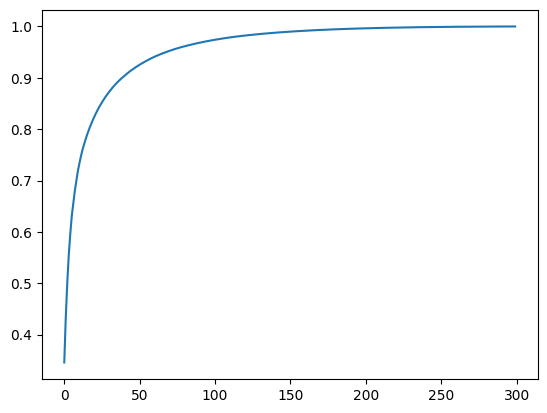

0.9742206

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=300)
R = pca.fit_transform(X[embedding_columns])
cumsum  = pca.explained_variance_ratio_.cumsum()
plt.plot(cumsum)
plt.show()
cumsum[100]

# Small experiment : find to 10 matching pictures ( through Tags) using cosine similarity between embeddings. Play with this by supplying difference Query_Object_ids

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

W = TagEmbeddedMet[embedding_columns]
cossimilarity_matrix = cosine_similarity(W)
print(cosine_similarity(W).shape)

(25187, 25187)


In [18]:
Query_Object_id = 150   #500

mask = met['Object_ID'] == Query_Object_id
print(met[mask]['Tags'])
url = met[mask]['Link_Resource'].values
print(url)

0    Feet|Heads|Dancers
Name: Tags, dtype: object
['http://www.metmuseum.org/art/collection/search/150']


### results

In [19]:
mask = TagEmbeddedMet['Object_ID'] == Query_Object_id
index = TagEmbeddedMet[mask].index.values[0]

res = cossimilarity_matrix[index]
res = pd.DataFrame(res)
res.sort_values(by = [0], ascending = False, inplace = True)
#display(res)  # index is the same as the index in TagEmbeddedMet

top  = list(res.iloc[2:12].index)
Query_result_top_5_matches_Object_IDs = list(TagEmbeddedMet.iloc[top]['Object_ID'].values)

print(Query_result_top_5_matches_Object_IDs)

for Object_ID in Query_result_top_5_matches_Object_IDs:
    mask = met['Object_ID'] == Object_ID
    print(met[mask]['Tags'])
    url = met[mask]['Link_Resource'].values
    print(url)
    print('\n')

[72892, 15562, 1848, 1559, 72895, 336424, 337509, 364538, 337682, 381936]
3533    Feet|Hands|Heads
Name: Tags, dtype: object
['http://www.metmuseum.org/art/collection/search/72892']


2213    Feet|Dancers
Name: Tags, dtype: object
['http://www.metmuseum.org/art/collection/search/15562']


25    Feet|Hands|Dancing|Dancers
Name: Tags, dtype: object
['http://www.metmuseum.org/art/collection/search/1848']


19    Faces|Heads|Dancers
Name: Tags, dtype: object
['http://www.metmuseum.org/art/collection/search/1559']


3534    Faces|Feet|Heads|Men
Name: Tags, dtype: object
['http://www.metmuseum.org/art/collection/search/72895']


5134    Feet|Hands|Heads|Men|Profiles
Name: Tags, dtype: object
['http://www.metmuseum.org/art/collection/search/336424']


5598    Feet|Hands|Girls|Profiles
Name: Tags, dtype: object
['http://www.metmuseum.org/art/collection/search/337509']


11252    Feet|Hands
Name: Tags, dtype: object
['http://www.metmuseum.org/art/collection/search/364538']


5695    Feet|Hands
